In [1]:
const ArrayType = Array
import DifferentialEquations: Tsit5
const solver_algo = Tsit5()
const MY_TYPE = Float32 # use float32 if you plan to use a GPU
import CUDA # Test if CUDA is running
if CUDA.functional()
    CUDA.allowscalar(false)
    const ArrayType = CuArray
    import DiffEqGPU: GPUTsit5
    const solver_algo = GPUTsit5()
end

# Learning a closure for the Gray-Scott model when using a coarser grid for $v$
In this example, we want to learn a closure to the Gray-Scott model using a Neural Network. Here we use a **coarser grid only on $v$**, while we keep the **fine grid for $u$**.
## Exact solution in *fine* grid - DNS
We run multiple GS simulations as discussed in the previous part.
*Note:* the *fine* grid is only 40 cells per side to speed up the example.

In [2]:
dux = duy = dvx = dvy = 1.0f0
nux = nuy = nvx = nvy = 40
import CoupledNODE: Grid, Laplacian
grid_GS_u = Grid(dim = 2, dx = dux, nx = nux, dy = duy, ny = nuy)
grid_GS_v = Grid(dim = 2, dx = dvx, nx = nvx, dy = dvy, ny = nvy)

Grid(2, 1.0f0, 1.0f0, 0.0f0, 40, 40, 0, 1600, Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0], Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0], nothing)

Let's define the initial condition as a random perturbation over a constant background to add variety.

In [3]:
function initial_condition(grid_u, grid_v, U₀, V₀, ε_u, ε_v; nsimulations = 1)
    u_init = U₀ .+ ε_u .* randn(grid_u.nx, grid_u.ny, nsimulations)
    v_init = V₀ .+ ε_v .* randn(grid_v.nx, grid_v.ny, nsimulations)
    return u_init, v_init
end
U₀ = 0.5f0    # initial concentration of u
V₀ = 0.25f0   # initial concentration of v
ε_u = 0.05f0  # magnitude of the perturbation on u
ε_v = 0.1f0   # magnitude of the perturbation on v
u_initial, v_initial = initial_condition(
    grid_GS_u, grid_GS_v, U₀, V₀, ε_u, ε_v, nsimulations = 4);

We can now define the initial condition as a flattened concatenated array.

In [4]:
uv0 = MY_TYPE.(vcat(
    reshape(u_initial, grid_GS_u.N, :), reshape(v_initial, grid_GS_v.nx * grid_GS_v.ny, :)));

From the literature, we have selected the following parameters in order to form nice patterns

In [5]:
D_u = 0.16f0
D_v = 0.08f0
f = 0.055f0
k = 0.062f0;

Definition of the right-hand-sides (RHS) or forces of GS model

In [6]:
import Zygote
function F_u(u, v)
    Zygote.@ignore MY_TYPE.(D_u * Laplacian(u, grid_GS_u.dx, grid_GS_u.dy) .- u .* v .^ 2 .+
                            f .* (1.0f0 .- u))
end
function G_v(u, v)
    Zygote.@ignore MY_TYPE.(D_v * Laplacian(v, grid_GS_v.dx, grid_GS_v.dy) .+ u .* v .^ 2 .-
                            (f + k) .* v)
end

G_v (generic function with 1 method)

Definition of the model

In [7]:
import CoupledNODE: create_f_CNODE
f_CNODE = create_f_CNODE((F_u, G_v), (grid_GS_u, grid_GS_v); is_closed = false);
import Random, LuxCUDA, Lux
rng = Random.seed!(1234)
θ, st = Lux.setup(rng, f_CNODE);

Short *burnout run* to get rid of the initial artifacts

In [8]:
trange_burn = (0.0f0, 50.0f0)
dt, saveat = (1e-2, 1)
using DiffEqFlux: NeuralODE
full_CNODE = NeuralODE(f_CNODE,
    trange_burn,
    solver_algo,
    adaptive = false,
    dt = dt,
    saveat = saveat);
burnout_data = Array(full_CNODE(uv0, θ, st)[1]);

Second burnout with larger timesteps

In [9]:
trange_burn = (0.0f0, 100.0f0)
dt, saveat = (1, 50)
full_CNODE = NeuralODE(f_CNODE,
    trange_burn,
    solver_algo,
    adaptive = false,
    dt = dt,
    saveat = saveat);
burnout_data = Array(full_CNODE(burnout_data[:, :, end], θ, st)[1]);

### Data collection run - exact solution in *fine* grid
We use the output of the burnout to start a longer simulation.

In [10]:
uv0 = burnout_data[:, :, end];
trange = (0.0f0, 2500.0f0);

for this data production run, we set `dt=1` and we sample every step.

In [11]:
dt, saveat = (0.1, 0.1);
full_CNODE = NeuralODE(
    f_CNODE, trange, solver_algo, adaptive = false, dt = dt, saveat = saveat);
reference_data = Array(full_CNODE(uv0, θ, st)[1]);

And we unpack the solution to get the two species from

In [12]:
u = reshape(reference_data[1:(grid_GS_u.N), :, :],
    grid_GS_u.nx,
    grid_GS_u.ny,
    :,
    size(reference_data)[end]);
v = reshape(reference_data[(grid_GS_v.N + 1):end, :, :],
    grid_GS_v.nx,
    grid_GS_v.ny,
    :,
    size(reference_data)[end]);

### Plot the data of the exact solution in the *fine* grid (DNS)

┌ Info: Saved animation to /var/folders/ls/dj0bf91x7715kphjd6dghv0w0000gn/T/jl_9y14T4za7w.gif
└ @ Plots /Users/luisaorozco/.julia/packages/Plots/ju9dp/src/animation.jl:156
┌ Info: Saved animation to /Users/luisaorozco/Documents/Projects/DEEPDIP/ref/examples/plots/02.04-DNS.gif
└ @ Plots /Users/luisaorozco/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/luisaorozco/Documents/Projects/DEEPDIP/ref/examples/plots/02.04-DNS.gif")
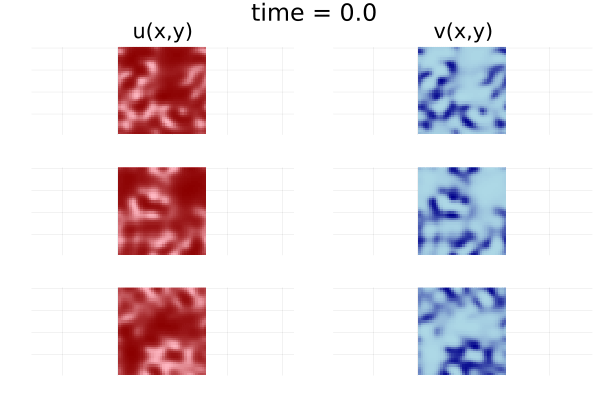

In [13]:
using Plots, Plots.PlotMeasures
anim = Animation()
fig = plot(layout = (3, 2), size = (600, 900))
@gif for i in 1:1000:size(u)[end]
    p1 = heatmap(u[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :reds,
        title = "u(x,y)")
    p2 = heatmap(v[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues,
        title = "v(x,y)")
    p3 = heatmap(u[:, :, 2, i], axis = false, cbar = false, aspect_ratio = 1, color = :reds)
    p4 = heatmap(v[:, :, 2, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    p5 = heatmap(u[:, :, 3, i], axis = false, cbar = false, aspect_ratio = 1, color = :reds)
    p6 = heatmap(v[:, :, 3, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    time = round(i * saveat, digits = 0)
    fig = plot(p1, p2, p3, p4, p5, p6, layout = (3, 2),
        plot_title = "time = $(time)", margin = 0mm)
    frame(anim, fig)
end
if isdir("./plots")
    gif(anim, "./plots/02.04-DNS.gif", fps = 10)
else
    gif(anim, "examples/plots/02.04-DNS.gif", fps = 10)
end

## Exact solution in a *coarse* grid for $v$ - LES
Let's solve the model in a *coarse* grid for $v$.
### Collect the LES data: *coarse* grid
We redefine the grid parameters in order to have a coarser grid for $v$.

In [14]:
nvx = nvy = 30
dvx = nux * dux / nvx
dvy = nuy * duy / nvy
coarse_grid = Grid(dim = 2, dx = dvx, nx = nvx, dy = dvy, ny = nvy)

Grid(2, 1.3333334f0, 1.3333334f0, 0.0f0, 30, 30, 0, 900, Float32[0.0, 1.3333334, 2.6666667, 4.0, 5.3333335, 6.6666665, 8.0, 9.333333, 10.666667, 12.0  …  26.666666, 28.0, 29.333334, 30.666666, 32.0, 33.333332, 34.666668, 36.0, 37.333332, 38.666668], Float32[0.0, 1.3333334, 2.6666667, 4.0, 5.3333335, 6.6666665, 8.0, 9.333333, 10.666667, 12.0  …  26.666666, 28.0, 29.333334, 30.666666, 32.0, 33.333332, 34.666668, 36.0, 37.333332, 38.666668], nothing)

Since the grid of $u$ is finer than the grid of $v$ we need to define two operations to transform
$v$ to the grid of $u$ prior to the force calculation and to transform the results of $v$ back to the coarser grid. This is specific to out problem, but `create_f_CNODE` allows us to define operaitons that have to take place prior and after the force calculation.

In [15]:
import Lux: Chain, Upsample, MeanPool, SkipConnection
"""
    upscale_v(grid_u, grid_v)

Generates a function that upscales `v` to the grid of `u`.

Arguments
- `grid_u`: The spatial grid of component `u`.
- `grid_v`: The spatial grid of component`v`.

Returns
A `Chain` object that upscales v, expects as input a tuple `(u, v)` and returns a tuple `(u, v)` with  `v` upscaled to the grid of `u`.
"""
function upscale_v(grid_u, grid_v)
    up_v = Chain(
        uv -> let u = uv[1], v = uv[2]
            #reshape v on the grid
            v = reshape(v, grid_v.nx, grid_v.ny, 1, size(v)[end])
            v
        end,
        Upsample(:trilinear, size = (grid_u.nx, grid_u.ny)))
    return Chain(SkipConnection(up_v,
        (v_up, uv) -> let u = uv[1]
            #get rid of batch dimension to match u dimensions
            v_up = reshape(v_up, grid_u.nx, grid_u.ny, size(v_up)[end])
            [u, v_up]
        end))
end

"""
    downscale_v(grid_u, grid_v)

Generates a function that downscales the `v` component from `grid_u` to `grid_v`.

Arguments
- `grid_u`: The spatial grid of component `u`.
- `grid_v`: The spatial grid of component`v`.

Returns
A `Chain` object representing the downscaling operation, expects as input a tuple `(u, v)` and returns the linearized concatenation of u and v.
"""
function downscale_v(grid_u, grid_v)
    dw_v = Chain(
        #extract only the v component
        uv -> let v = uv[2]
            #to apply upsample you need a 4th dumb dimension to represent the channels/batch
            v = reshape(v, size(v, 1), size(v, 2), size(v, 3), 1)
            v
        end,
        #to downscale we first have to upscale to twice the target size
        Upsample(:trilinear, size = (2 * grid_v.nx, 2 * grid_v.ny)),
        MeanPool((2, 2)))
    return Chain(SkipConnection(dw_v,
        (v_dw, uv) -> let u = uv[1]
            #make u and v linear removing the dumb dimension
            nbatch = size(u)[end]
            u = reshape(u, grid_u.nx, grid_u.ny, nbatch)
            v = reshape(v_dw, grid_v.nx, grid_v.ny, nbatch)
            (u, v)
        end))
end

downscale_v

Define our upscaler and downscaler functions

In [16]:
upscaler_v = upscale_v(grid_GS_u, coarse_grid)
downscaler_v = downscale_v(grid_GS_u, coarse_grid)

SkipConnection(
    Chain(
        layer_1 = WrappedFunction(#18),
        layer_2 = Upsample(:trilinear, size = (60, 60)),
        layer_3 = MeanPool((2, 2)),
    ),
    #19
)         # Total: 0 parameters,
          #        plus 0 states.

Let's see what happens if we use a non-closed model on a smaller grid
(we are not using any NN here).

In [17]:
using Images
f_coarse_CNODE = create_f_CNODE(
    (F_u, G_v), (grid_GS_u, coarse_grid), pre_force = upscaler_v,
    post_force = downscaler_v; is_closed = false)
θ, st = Lux.setup(rng, f_coarse_CNODE);
uv0 = burnout_data[:, :, end];
u0b = reshape(uv0[1:(grid_GS_u.N), :], grid_GS_u.nx, grid_GS_u.ny, :);
v0b = reshape(uv0[(grid_GS_v.N + 1):end, :], grid_GS_v.nx, grid_GS_v.ny, :);
v0_coarse = imresize(v0b, (coarse_grid.nx, coarse_grid.ny));
uv0_coarse = vcat(reshape(u0b, grid_GS_u.N, :), reshape(v0_coarse, coarse_grid.N, :));

### Define model without closure: LES

In [18]:
les_CNODE = NeuralODE(f_coarse_CNODE,
    trange,
    solver_algo,
    adaptive = false,
    dt = dt,
    saveat = saveat);
les_solution = Array(les_CNODE(uv0_coarse, θ, st)[1]);
u_les = reshape(les_solution[1:(grid_GS_u.N), :, :],
    grid_GS_u.nx,
    grid_GS_u.ny,
    :,
    size(les_solution)[end]);
v_les = reshape(les_solution[(grid_GS_u.N + 1):end, :, :],
    coarse_grid.nx,
    coarse_grid.ny,
    :,
    size(les_solution)[end]);

### Plot the results of LES (no closure)

┌ Info: Saved animation to /var/folders/ls/dj0bf91x7715kphjd6dghv0w0000gn/T/jl_heHUdMJuBG.gif
└ @ Plots /Users/luisaorozco/.julia/packages/Plots/ju9dp/src/animation.jl:156
┌ Info: Saved animation to /Users/luisaorozco/Documents/Projects/DEEPDIP/ref/examples/plots/02.04-LES.gif
└ @ Plots /Users/luisaorozco/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/luisaorozco/Documents/Projects/DEEPDIP/ref/examples/plots/02.04-LES.gif")
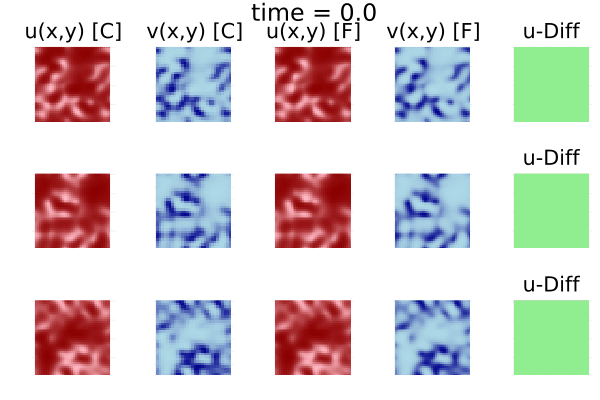

In [19]:
anim = Animation()
fig = plot(layout = (3, 5), size = (500, 300))
@gif for i in 1:1000:size(u_les)[end]
    p1 = heatmap(u_les[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :reds,
        title = "u(x,y) [C]")
    p2 = heatmap(v_les[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues,
        title = "v(x,y) [C]")
    p3 = heatmap(u[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :reds,
        title = "u(x,y) [F]")
    p4 = heatmap(v[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues,
        title = "v(x,y) [F]")
    e = u_les[:, :, 1, i] .- u[:, :, 1, i]
    p5 = heatmap(e,
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :greens,
        title = "u-Diff")
    p6 = heatmap(u_les[:, :, 2, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :reds)
    p7 = heatmap(v_les[:, :, 2, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    p8 = heatmap(u[:, :, 2, i], axis = false, cbar = false, aspect_ratio = 1, color = :reds)
    p9 = heatmap(v[:, :, 2, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    e = u_les[:, :, 2, i] .- u[:, :, 2, i]
    p10 = heatmap(e,
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :greens,
        title = "u-Diff")
    p11 = heatmap(u_les[:, :, 3, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :reds)
    p12 = heatmap(v_les[:, :, 3, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    p13 = heatmap(u[:, :, 3, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :reds)
    p14 = heatmap(v[:, :, 3, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    error = u_les[:, :, 3, i] .- u[:, :, 3, i]
    p15 = heatmap(error,
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :greens,
        title = "u-Diff")
    time = round(i * saveat, digits = 0)
    fig = plot(p1,
        p2,
        p3,
        p4,
        p5,
        p6,
        p7,
        p8,
        p9,
        p10,
        p11,
        p12,
        p13,
        p14,
        p15,
        layout = (3, 5),
        plot_title = "time = $(time)",
        margin = 0mm)
    frame(anim, fig)
end
if isdir("./plots")
    gif(anim, "./plots/02.04-LES.gif", fps = 10)
else
    gif(anim, "examples/plots/02.04-LES.gif", fps = 10)
end

## Closure model + LES
Now let's train a Neural Network closure that added to a *coarse* grid solution of $v$ (LES) would approximate the *fine* gride results (DNS).
### Prepare reference data (labels)
In order to prepare the loss function, we compute from the simulation data the target that we would like to fit. In the example $u$ will be unchanged, while $v$ will be rescaled to the coarse grid.

In [20]:
u_target = reshape(reference_data[1:(grid_GS_u.N), :, :],
    grid_GS_u.nx,
    grid_GS_u.ny,
    :,
    size(reference_data)[end]);
v_target = reshape(reference_data[(grid_GS_u.N + 1):end, :, :],
    grid_GS_v.nx,
    grid_GS_v.ny,
    :,
    size(reference_data)[end]);
v_target = imresize(v_target, (coarse_grid.nx, coarse_grid.ny));

Pack $u$ and $v$ together in a `target` array where $u$ and $v$ are linearized in the first dimension. This is because `ODEProblem` expects as single dimension array as input.

In [21]:
target = vcat(reshape(u_target, grid_GS_u.N, :, size(u_target)[end]),
    reshape(v_target, coarse_grid.N, :, size(v_target)[end]));

### Closure Model
Let's create the CNODE with the Neural Network closure. In this case we are going to use two different neural networks for the two components $u$ and $v$.

In [22]:
import CoupledNODE: create_fno_model
ch_fno = [1, 5, 5, 5, 2];
kmax_fno = [8, 8, 8, 8];
σ_fno = [Lux.gelu, Lux.gelu, Lux.gelu, identity];
NN_u = create_fno_model(kmax_fno, ch_fno, σ_fno, grid_GS_u, (x -> let u = x[1]
    u
end,), init_weight = Lux.zeros32);
NN_v = create_fno_model(kmax_fno, ch_fno, σ_fno, grid_GS_u, (x -> let v = x[2]
    v
end,), init_weight = Lux.zeros32);
f_closed_CNODE = create_f_CNODE((F_u, G_v), (grid_GS_u, coarse_grid), (NN_u, NN_v),
    pre_force = upscaler_v, post_force = downscaler_v; is_closed = true);

# Get the model parameters
θ, st = Lux.setup(rng, f_closed_CNODE);

### Design the **loss function**
For this example, we use *multishooting a posteriori* fitting (MulDtO), where we tell `Zygote` to compare `nintervals` of length `nunroll` to get the gradient. Notice that this method is differentiating through the solution of the NODE!

In [23]:
nunroll = 5
nintervals = 10
nsamples = 2

2

We also define this auxiliary NODE `training_CNODE` that will be used for training so that we can use smaller time steps for the training.

In [24]:
dt_train = 0.1

0.1

but we have to sample at the same rate as the data

In [25]:
saveat_train = saveat
t_train_range = (0.0f0, saveat_train * nunroll) # it has to be as long as nunroll
training_CNODE = NeuralODE(f_closed_CNODE,
    t_train_range,
    solver_algo,
    adaptive = false,
    dt = dt_train,
    saveat = saveat_train);

Create the loss

In [26]:
import CoupledNODE: create_randloss_MulDtO
myloss = create_randloss_MulDtO(target,
    training_CNODE,
    st,
    nunroll = nunroll,
    nintervals = nintervals,
    nsamples = nsamples,
    λ_c = 1e2,
    λ_l1 = 1e-1);

# Initialize and trigger the compilation of the model
import ComponentArrays
pinit = ComponentArrays.ComponentArray(θ);
myloss(pinit) # trigger compilation

(683505.9842076203, nothing)

[!] Check that the loss does not get type warnings, otherwise it will be slower

### Transform the NeuralODE into an optimization problem

In [27]:
import OptimizationOptimisers: Optimization, OptimiserChain, Adam, ClipGrad

* Select the autodifferentiation type

In [28]:
adtype = Optimization.AutoZygote();
optf = Optimization.OptimizationFunction((x, p) -> myloss(x), adtype);
optprob = Optimization.OptimizationProblem(optf, pinit);

* Select the training algorithm
We choose Adam with learning rate 0.1, with gradient clipping

In [29]:
ClipAdam = OptimiserChain(Adam(1.0f-1), ClipGrad(1));

### Train the CNODE
(The block can be repeated to continue training)

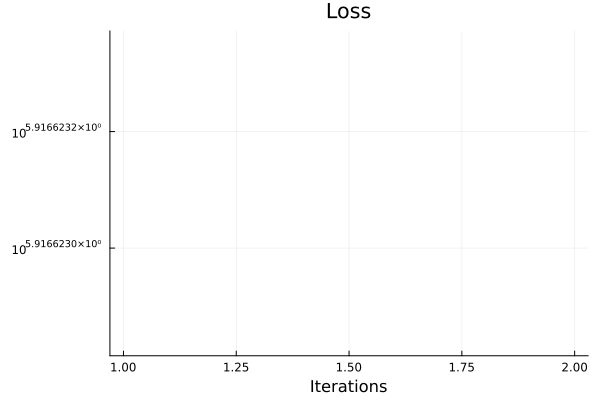

Loss[0]: 825320.8767888987
Loss[1]: 89561.80542964442
Loss[2]: 744119.7746046837
Loss[3]: 818268.9140901049
Loss[4]: 817450.2803243358
Loss[5]: 820862.8076776218
Loss[6]: 822807.7169266925
Loss[7]: 854037.1041153631
Loss[8]: 31644.512940318156
Loss[9]: 712521.815179418
Loss[10]: 711475.5251760369
Loss[11]: 781240.221801736
Loss[12]: 18189.968797312635
Loss[13]: 50571.75286749789
Loss[14]: 989364.540749806
Loss[15]: 823795.2937771499
Loss[16]: 1.1490927458757048e6
Loss[17]: 816173.6461511962
Loss[18]: 790283.7924474063
Loss[19]: 789353.5121173253
Loss[20]: 18189.968797312635


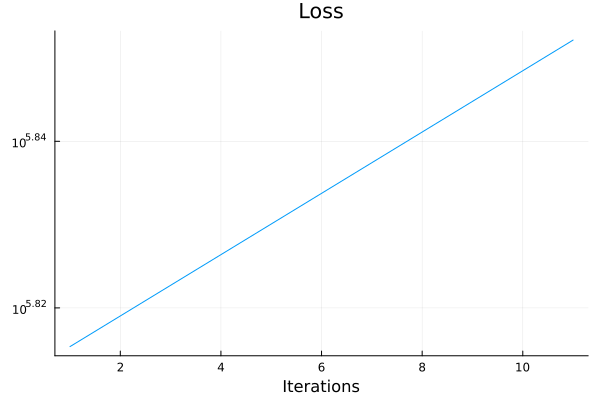

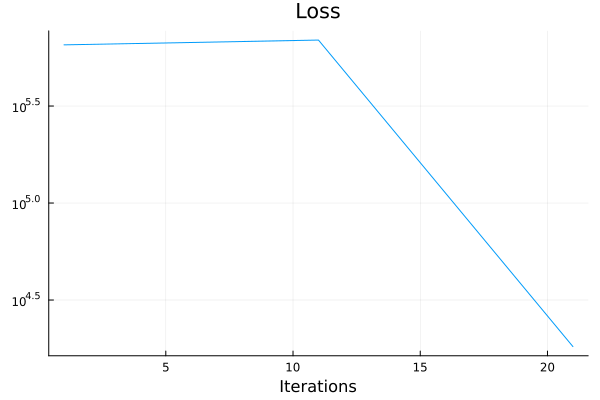

In [30]:
import CoupledNODE: callback
result_neuralode = Optimization.solve(optprob,
    ClipAdam;
    callback = callback,
    maxiters = 20);
pinit = result_neuralode.u;
θ = pinit;
optprob = Optimization.OptimizationProblem(optf, pinit);

*Note:* the training is rather slow, so realistically here we can not expect good results in a few iterations.

## Analyse the results
Let's use `trained_CNODE` to compare the solution with the target.

┌ Info: Saved animation to /var/folders/ls/dj0bf91x7715kphjd6dghv0w0000gn/T/jl_ZidohgdmpO.gif
└ @ Plots /Users/luisaorozco/.julia/packages/Plots/ju9dp/src/animation.jl:156
┌ Info: Saved animation to /Users/luisaorozco/Documents/Projects/DEEPDIP/ref/examples/plots/02.04-NNclosure.gif
└ @ Plots /Users/luisaorozco/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/luisaorozco/Documents/Projects/DEEPDIP/ref/examples/plots/02.04-NNclosure.gif")
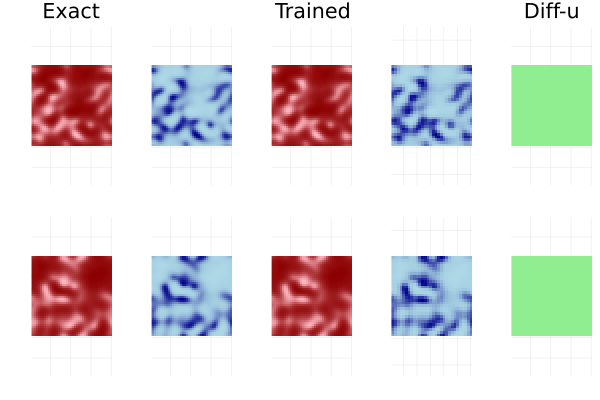

In [31]:
trange = (0.0f0, 300.0f0)
trained_CNODE = NeuralODE(f_closed_CNODE,
    trange,
    solver_algo,
    adaptive = false,
    dt = dt,
    saveat = saveat);
trained_CNODE_solution = Array(trained_CNODE(uv0_coarse[:, 1:3], θ, st)[1]);

u_trained = reshape(trained_CNODE_solution[1:(grid_GS_u.N), :, :],
    grid_GS_u.nx,
    grid_GS_u.ny,
    :,
    size(trained_CNODE_solution)[end]);
v_trained = reshape(trained_CNODE_solution[(grid_GS_u.N + 1):end, :, :],
    coarse_grid.nx,
    coarse_grid.ny,
    :,
    size(trained_CNODE_solution)[end]);

anim = Animation()
fig = plot(layout = (2, 5), size = (750, 300))
@gif for i in 1:40:size(u_trained)[end]
    p1 = heatmap(u[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :reds,
        title = "Exact")
    p2 = heatmap(v[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    p3 = heatmap(u_trained[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :reds,
        title = "Trained")
    p4 = heatmap(v_trained[:, :, 1, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    et = abs.(u[:, :, 1, i] .- u_trained[:, :, 1, i])
    p5 = heatmap(et,
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :greens,
        title = "Diff-u")
    p6 = heatmap(u[:, :, 2, i], axis = false, cbar = false, aspect_ratio = 1, color = :reds)
    p7 = heatmap(v[:, :, 2, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    p8 = heatmap(u_trained[:, :, 2, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :reds)
    p9 = heatmap(v_trained[:, :, 2, i],
        axis = false,
        cbar = false,
        aspect_ratio = 1,
        color = :blues)
    e = abs.(u[:, :, 2, i] .- u_trained[:, :, 2, i])
    p10 = heatmap(e, axis = false, cbar = false, aspect_ratio = 1, color = :greens)

    time = round(i * saveat, digits = 0)
    fig = plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, layout = (2, 5), margin = 0mm)

    frame(anim, fig)
end
if isdir("./plots")
    gif(anim, "./plots/02.04-NNclosure.gif", fps = 10)
else
    gif(anim, "examples/plots/02.04-NNclosure.gif", fps = 10)
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*